<a href="https://colab.research.google.com/github/juank2572/codigo-LSTM-MultivariadoJuan-Carlos-Anaya-/blob/main/MODELO_LSTM_UNIVARIADO_JUAN_ANAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


El bloque establece el entorno mínimo para un modelo LSTM univariante de series temporales: se importan NumPy (operaciones numéricas vectorizadas) y Pandas (estructura DataFrame para manipular la única serie objetivo), junto con Matplotlib para trazados de diagnóstico y verificación visual; se incorpora MinMaxScaler para llevar la serie a un rango acotado —habitualmente — que estabiliza la optimización basada en gradientes; finalmente, se carga una arquitectura secuencial de Keras con las capas LSTM y Dense, donde LSTM modela dependencias temporales de la serie y la capa Dense produce la predicción escalar del siguiente instante a partir del estado recurrente.

In [ ]:
#Verificar que Google Drive está montado correctamente
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importar base de datos
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Ruta completa del archivo en tu Google Drive
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/archivo_transformado.xlsx'

# Leer el archivo en un DataFrame de Pandas
df = pd.read_excel(ruta_archivo)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Este bloque monta Google Drive en el entorno Colab para acceder a archivos, importa Pandas y carga en un DataFrame un libro de Excel ubicado en la ruta absoluta indicada; en concreto, drive.mount('/content/drive') autoriza el acceso al almacenamiento y lo expone en el árbol de archivos, se define la variable ruta_archivo con la ubicación del Excel previamente transformado y, con pd.read_excel, se lee su contenido en df, que queda listo para inspección, limpieza y modelado posterior.

In [ ]:
df = pd.read_excel(ruta_archivo)
df.head()


,Datetime,value
0,2015-01-01 00:00:00,184.210107
1,2015-01-01 01:00:00,178.210107
2,2015-01-01 02:00:00,178.210107
3,2015-01-01 03:00:00,178.210107
4,2015-01-01 04:00:00,178.210107


A partir de la ruta previamente definida se importa el libro de Excel a un DataFrame de Pandas y se muestra una vista preliminar de los primeros registros con head(): df = pd.read_excel(ruta_archivo); df.head().



In [ ]:
#Celda 2: Cargar y preparar los datos
# Ruta al archivo en Google Drive
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/archivo_transformado.xlsx'

# Cargar los datos en un DataFrame
df = pd.read_excel(ruta_archivo)

# Asegurarse de que la columna 'Datetime' esté en formato datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Establecer 'Datetime' como índice del DataFrame
df.set_index('Datetime', inplace=True)

# Visualizar las primeras filas de los datos
df.head()


,value
Datetime,
2015-01-01 00:00:00,184.210107
2015-01-01 01:00:00,178.210107
2015-01-01 02:00:00,178.210107
2015-01-01 03:00:00,178.210107
2015-01-01 04:00:00,178.210107


Este bloque carga en memoria un libro de Excel con datos ya transformados, garantiza que la columna temporal esté correctamente tipada y organiza el DataFrame para análisis de series: primero se define la ruta del archivo dentro de Drive y se lee con Pandas en df; enseguida se convierte la columna Datetime al tipo datetime64 para habilitar operaciones temporales fiables (resampleos, filtrados por rango, extracción de atributos de fecha), y se fija dicha columna como índice, lo que facilita consultas cronológicas y métodos específicos de series temporales; finalmente se muestran las primeras filas para verificar que la ingestión y la indexación quedaron correctas en estructura, tipos y encabezados.

In [ ]:
# Celda 3: Preprocesamiento de los datos
# Crear un objeto MinMaxScaler para normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalizar la columna 'value'
datos_normalizados = scaler.fit_transform(df['value'].values.reshape(-1, 1))

# Función para crear las secuencias
def crear_secuencias(datos, pasos_temporales):
    X, y = [], []
    for i in range(len(datos) - pasos_temporales):
        X.append(datos[i:(i + pasos_temporales), 0])
        y.append(datos[i + pasos_temporales, 0])
    return np.array(X), np.array(y)

# Número de pasos temporales (días) que usaremos para predecir el siguiente día
pasos_temporales = 30  # Usamos los últimos 30 días

# Crear las secuencias de entrenamiento
X, y = crear_secuencias(datos_normalizados, pasos_temporales)

# Remodelar X para que sea compatible con el modelo LSTM: [muestras, pasos temporales, características]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Mostrar las primeras filas de los datos normalizados
print("Datos normalizados (primeras filas):")
print(datos_normalizados[:5])  # Muestra los primeros 5 datos

# También puedes verificar que la forma de X y y sea correcta
print(f'Tamaño de X: {X.shape}')
print(f'Tamaño de y: {y.shape}')



Datos normalizados (primeras filas):
[[0.04952505]
 [0.04736268]
 [0.04736268]
 [0.04736268]
 [0.04736268]]
Tamaño de X: (87618, 30, 1)
Tamaño de y: (87618,)


Esta parte del código prepara la serie univariante para alimentarla a una LSTM mediante escalado y ventanas deslizantes: primero crea un MinMaxScaler que lleva la variable objetivo al rango , con lo que se estabiliza la magnitud de gradientes y se acelera la convergencia; después aplica fit_transform sobre la columna value y obtiene un arreglo 2D normalizado; a continuación define una rutina crear_secuencias que implementa el esquema de ventana deslizante, generando pares entrada–salida donde cada X contiene pasos_temporales observaciones consecutivas y el y asociado es el valor inmediatamente posterior, lo que permite al modelo aprender dependencias temporales de orden finito; con pasos_temporales=30 se generan las matrices X,y y luego X se remodela a la forma requerida por Keras [muestras, pasos, características]=(n,30,1); por último, se imprimen las primeras filas escaladas y las formas de X e y para verificar que el preprocesamiento produjo tensores con dimensiones consistentes para entrenamiento de la LSTM.

In [ ]:
# Dividir los datos en entrenamiento y prueba
tamaño_entrenamiento = int(len(X) * 0.8)

# Crear los conjuntos de entrenamiento y prueba
X_entrenamiento, X_prueba = X[:tamaño_entrenamiento], X[tamaño_entrenamiento:]
y_entrenamiento, y_prueba = y[:tamaño_entrenamiento], y[tamaño_entrenamiento:]

# Verificar el tamaño de los datos de entrenamiento y prueba
print(f'Tamaño de los datos de entrenamiento: {X_entrenamiento.shape}')
print(f'Tamaño de los datos de prueba: {X_prueba.shape}')


Tamaño de los datos de entrenamiento: (70094, 30, 1)
Tamaño de los datos de prueba: (17524, 30, 1)


El fragmento separa cronológicamente el conjunto de secuencias para validar el modelo en datos no vistos y confirma las dimensiones resultantes: primero calcula el punto de corte como el 80% del total de muestras y, respetando el orden temporal, asigna las primeras observaciones a entrenamiento y las restantes a prueba, tanto para X como para y; esta división sin mezclado evita fugas de información desde el futuro y emula el uso real del sistema de pronóstico; por último, imprime las formas de X_entrenamiento y X_prueba, lo que permite verificar que ambas conservan la estructura requerida por la LSTM, esto es, [n_muestras, pasos_temporales, n_características], y que y mantiene la longitud coherente con cada partición.

In [ ]:
# Crear el modelo LSTM
modelo = Sequential()

# Primera capa LSTM
modelo.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))

# Segunda capa LSTM
modelo.add(LSTM(units=50))

# Capa densa de salida (un solo valor)
modelo.add(Dense(units=1))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
modelo.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


El script construye y compila un LSTM apilado para pronóstico univariante con Keras de forma mínima pero correcta: se crea un modelo secuencial, se añade una primera capa LSTM con 50 unidades que devuelve secuencias para preservar la dimensión temporal hacia la siguiente capa, seguida de una segunda LSTM con 50 unidades que condensa la información de la ventana en un estado oculto final; luego se incorpora una capa densa con una única neurona para producir la predicción escalar del siguiente paso; el modelo se compila con el optimizador Adam y pérdida de error cuadrático medio, apropiada para regresión en series; por último, se imprime el resumen para verificar forma de tensores, número de parámetros y compatibilidad de la entrada especificada como (pasos_temporales, 1), lo que debe coincidir con la forma de X preparada previamente.

Epoch 1/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 75s 33ms/step - loss: 3.9946e-04 - val_loss: 0.0012
Epoch 2/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - loss: 1.3645e-04 - val_loss: 0.0013
Epoch 3/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 69s 32ms/step - loss: 1.3306e-04 - val_loss: 0.0011
Epoch 4/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 89s 35ms/step - loss: 1.3236e-04 - val_loss: 0.0011
Epoch 5/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 73s 31ms/step - loss: 1.2764e-04 - val_loss: 0.0012
Epoch 6/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 1.4192e-04 - val_loss: 0.0011
Epoch 7/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 87s 34ms/step - loss: 1.1560e-04 - val_loss: 0.0012
Epoch 8/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 71s 32ms/step - loss: 1.3813e-04 - val_loss: 0.0011
Epoch 9/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - loss: 1.2244e-04 - val_loss: 0.0011
Epoch 10/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 72s 33ms/step - loss: 1.2468e-04 - val_loss: 0.0013
Epoch 11/50
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - 

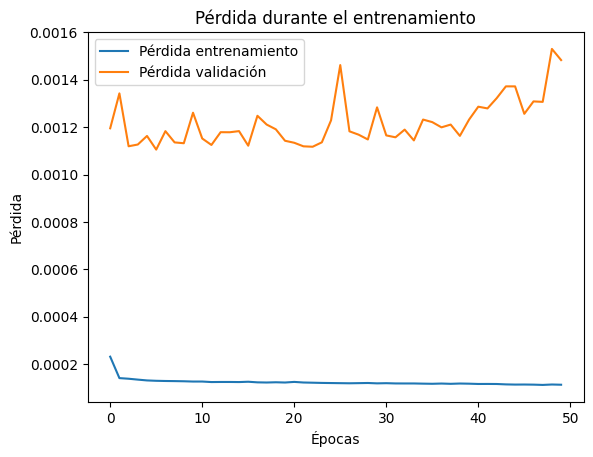

In [ ]:
# Entrenar el modelo
historia = modelo.fit(X_entrenamiento, y_entrenamiento, epochs=50, batch_size=32, validation_data=(X_prueba, y_prueba))

# Graficar la pérdida de entrenamiento y validación
plt.plot(historia.history['loss'], label='Pérdida entrenamiento')
plt.plot(historia.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Este bloque ajusta la red y visualiza la evolución de la función de pérdida en entrenamiento y validación: primero se entrena durante 50 épocas con tamaño de lote 32, usando como validación el bloque temporal reservado, lo que permite monitorizar la generalización en datos no vistos; el objeto historia almacena, por época, los valores de loss y val_loss, que luego se dibujan en un mismo gráfico para detectar convergencia, sobreajuste o mesetas; títulos y etiquetas documentan las curvas, la leyenda distingue ambas trayectorias y la visualización resultante es clave para decidir si conviene introducir detención temprana, reducir la tasa de aprendizaje, aumentar épocas, o ajustar arquitectura y regularización.

In [ ]:
# Guardar el modelo entrenado
modelo.save('/content/drive/MyDrive/Colab Notebooks/modelo_lstm.h5')
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


2191/2191 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 1.4458e-04
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.6339e-04
Pérdida en entrenamiento: 0.00010650369222275913
Pérdida en prueba: 0.001483044819906354
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


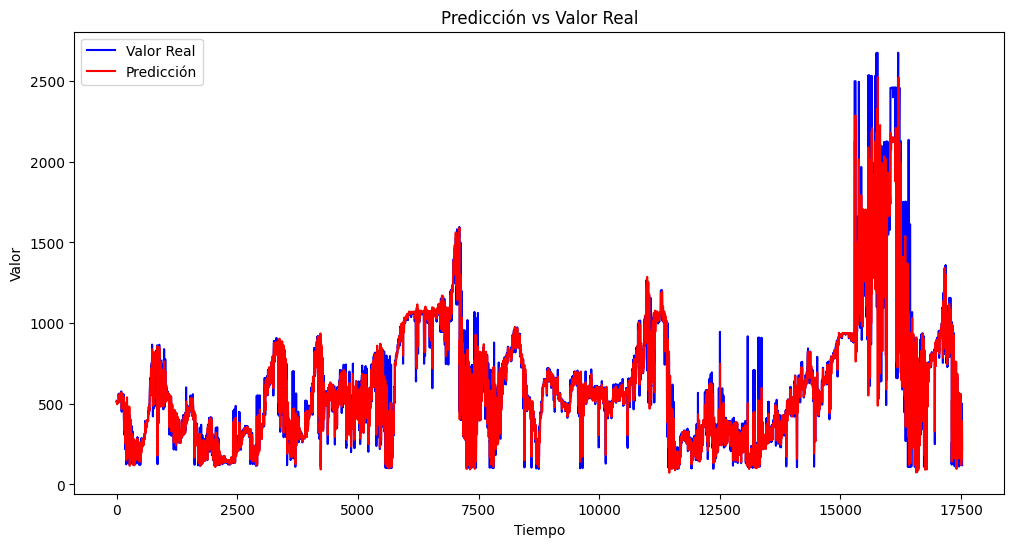

In [ ]:
# Evaluar el modelo
perdida_entrenamiento = modelo.evaluate(X_entrenamiento, y_entrenamiento)
perdida_prueba = modelo.evaluate(X_prueba, y_prueba)
print(f'Pérdida en entrenamiento: {perdida_entrenamiento}')
print(f'Pérdida en prueba: {perdida_prueba}')

# Hacer predicciones con los datos de prueba
predicciones = modelo.predict(X_prueba)

# Desnormalizar las predicciones
predicciones_desnormalizadas = scaler.inverse_transform(predicciones)

# Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_prueba.reshape(-1, 1)), color='blue', label='Valor Real')
plt.plot(predicciones_desnormalizadas, color='red', label='Predicción')
plt.title('Predicción vs Valor Real')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()


El bloque cuantifica el error en ambas particiones, proyecta sobre el conjunto de prueba y grafica resultados en la escala original: primero evalúa la función de pérdida sobre entrenamiento y prueba para contrastar ajuste y generalización; después genera predicciones para X_prueba y las lleva a unidades físicas aplicando el inverso del MinMaxScaler, operación que también se aplica a y_prueba para asegurar comparabilidad; por último, construye una figura con la serie real en azul y la predicción en rojo, lo que permite inspeccionar visualmente sesgos, desfasajes y amplitud de errores a lo largo del tiempo y facilita detectar si el modelo subestima picos o suaviza excesivamente la señal.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/

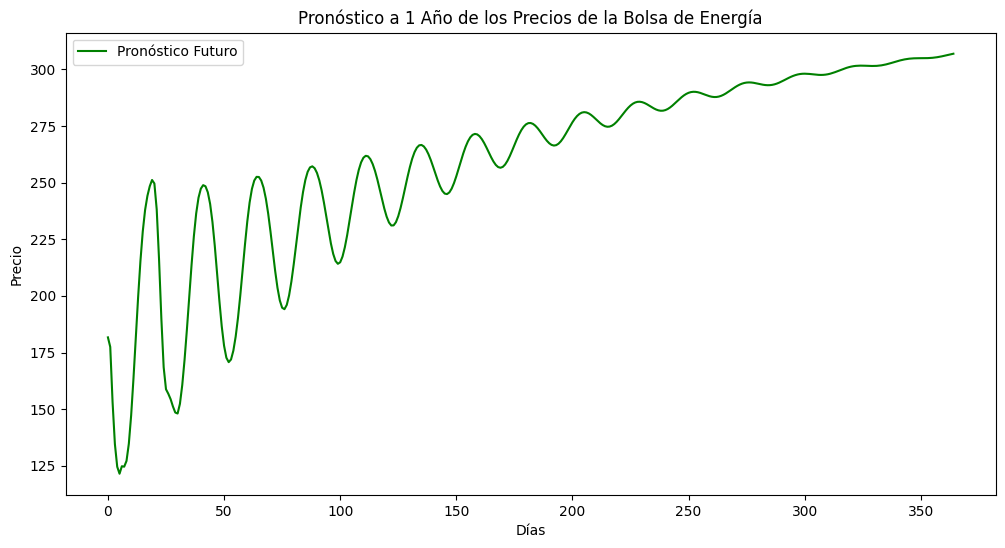

In [ ]:
# Pronóstico para el próximo año (365 días)
dias_a_predecir = 365
predicciones_futuras = []

# Usar los últimos 30 días para la primera predicción
entrada_actual = datos_normalizados[-pasos_temporales:]

for _ in range(dias_a_predecir):
    entrada_actual = entrada_actual.reshape((1, pasos_temporales, 1))
    prediccion = modelo.predict(entrada_actual)
    predicciones_futuras.append(prediccion[0, 0])
    entrada_actual = np.append(entrada_actual[:, 1:, :], prediccion.reshape(1, 1, 1), axis=1)

# Desnormalizar las predicciones futuras
predicciones_futuras_desnormalizadas = scaler.inverse_transform(np.array(predicciones_futuras).reshape(-1, 1))

# Visualizar las predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(predicciones_futuras_desnormalizadas, color='green', label='Pronóstico Futuro')
plt.title('Pronóstico a 1 Año de los Precios de la Bolsa de Energía')
plt.xlabel('Días')
plt.ylabel('Precio')
plt.legend()
plt.show()


Este bloque realiza un pronóstico autoregresivo de 365 pasos utilizando una ventana deslizante de 30 días: define el horizonte en días_a_predecir y una lista para acumular las predicciones, toma como semilla los últimos 30 valores escalados y, en cada iteración, remodela la entrada a la forma requerida por la LSTM, obtiene la predicción del siguiente día, la agrega a la lista y actualiza la ventana desplazando un paso e insertando el valor recién predicho, de modo que las proyecciones se alimentan de predicciones previas; al finalizar, transforma las predicciones a la escala original aplicando el inverso del MinMaxScaler y las grafica, lo que permite visualizar la trayectoria anual prevista; al ser un esquema iterativo, conviene interpretar el resultado con cautela por la acumulación de error y, si es posible, contrastarlo con bandas de incertidumbre o escenarios alternativos.

548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


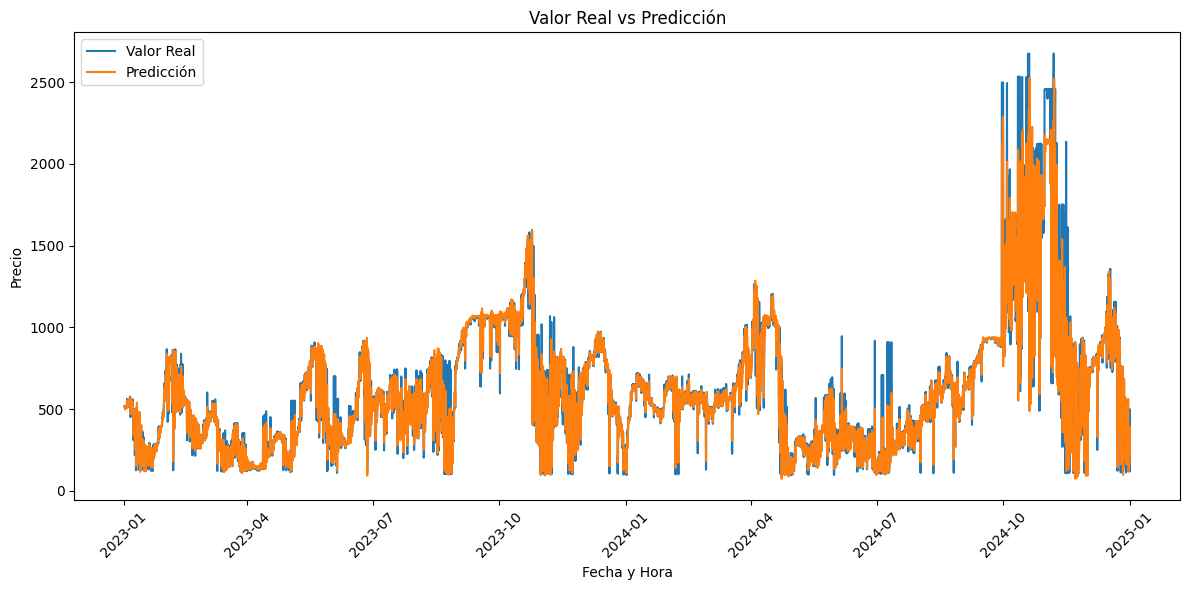

,Fecha y Hora,Valor Real,Predicción,Error
0,2023-01-01 20:00:00,518.40,513.081055,5.318945
1,2023-01-01 21:00:00,518.40,514.466431,3.933569
2,2023-01-01 22:00:00,510.90,515.090576,4.190576
3,2023-01-01 23:00:00,510.90,509.913940,0.986060
4,2023-01-02 00:00:00,509.35,508.039917,1.310083


In [ ]:
# Hacer predicciones en el conjunto de prueba
predicciones = modelo.predict(X_prueba)

# Desnormalizar las predicciones
predicciones_desnormalizadas = scaler.inverse_transform(predicciones)

# Desnormalizar los valores reales (y_prueba)
y_prueba_desnormalizado = scaler.inverse_transform(y_prueba.reshape(-1, 1))

# Calcular el error absoluto entre las predicciones y los valores reales
errores = np.abs(predicciones_desnormalizadas - y_prueba_desnormalizado)

# Crear un DataFrame con las columnas necesarias
resultados = pd.DataFrame({
    'Fecha y Hora': df.index[-len(y_prueba):],  # Las fechas correspondientes a los datos de prueba
    'Valor Real': y_prueba_desnormalizado.flatten(),
    'Predicción': predicciones_desnormalizadas.flatten(),
    'Error': errores.flatten()
})

# Mostrar la tabla con los resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(resultados['Fecha y Hora'], resultados['Valor Real'], label='Valor Real')
plt.plot(resultados['Fecha y Hora'], resultados['Predicción'], label='Predicción')
plt.title('Valor Real vs Predicción')
plt.xlabel('Fecha y Hora')
plt.ylabel('Precio')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar las primeras filas de la tabla
resultados.head()


Este bloque construye una tabla alineada temporalmente con el tramo de prueba y visualiza la comparación entre observado y predicho: primero genera predicciones para X_prueba y las devuelve a la escala original con el inverso del MinMaxScaler, realizando la misma operación sobre y_prueba; luego calcula el error absoluto punto a punto y arma un DataFrame con las columnas Fecha y Hora, Valor Real, Predicción y Error, usando como índice temporal las últimas len(y_prueba) marcas del DataFrame original, lo que garantiza sincronía; finalmente, grafica ambas series en el tiempo con etiquetas y formato legible (rotación de fechas y ajuste de diseño) y muestra las primeras filas de la tabla, útil para inspección rápida y para exportar resultados en caso de necesitar reporte o análisis posterior.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cálculo de las métricas estadísticas
mse = mean_squared_error(y_prueba_desnormalizado, predicciones_desnormalizadas)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_prueba_desnormalizado, predicciones_desnormalizadas)
r2 = r2_score(y_prueba_desnormalizado, predicciones_desnormalizadas)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')


MSE: 11418.140984284366
RMSE: 106.85570169291093
MAE: 43.76930481408165
R²: 0.9282887265065378


El fragmento calcula métricas estándar de regresión en la misma escala física de la variable objetivo y las imprime para evaluar precisión y generalización: primero obtiene el MSE sobre el tramo de prueba y deriva el RMSE como su raíz cuadrada para cuantificar el error típico en unidades originales; luego calcula el MAE como discrepancia absoluta promedio, menos sensible a outliers que el RMSE, y finalmente evalúa el coeficiente de determinación R², que compara el error del modelo con el de un predictor ingenuo que siempre devuelve la media de los valores reales; estas cuatro métricas, combinadas, permiten juzgar magnitud, robustez y mejora relativa del modelo, por lo que son una base adecuada para comparar configuraciones o establecer criterios de aceptación antes de desplegar el sistema.

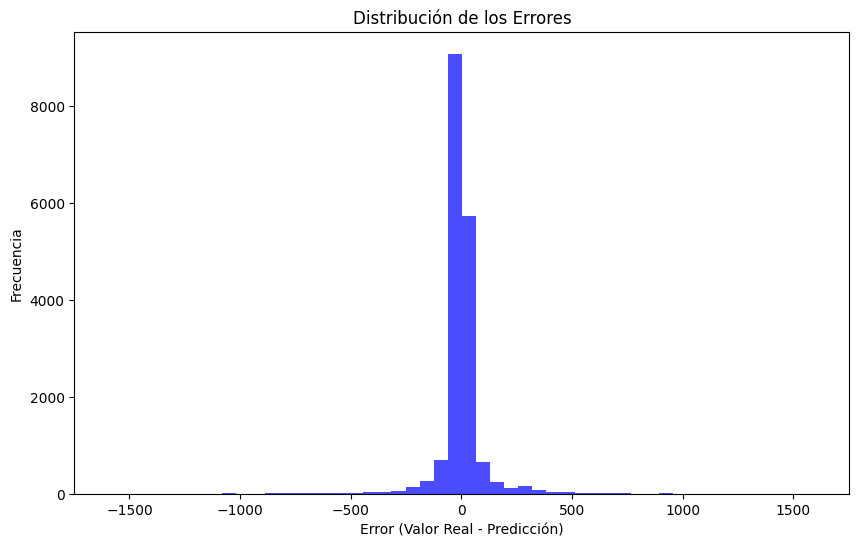

In [ ]:
# Calcular los errores
errores = y_prueba_desnormalizado - predicciones_desnormalizadas

# Graficar el histograma de los errores
plt.figure(figsize=(10, 6))
plt.hist(errores, bins=50, alpha=0.7, color='blue')
plt.title('Distribución de los Errores')
plt.xlabel('Error (Valor Real - Predicción)')
plt.ylabel('Frecuencia')
plt.show()


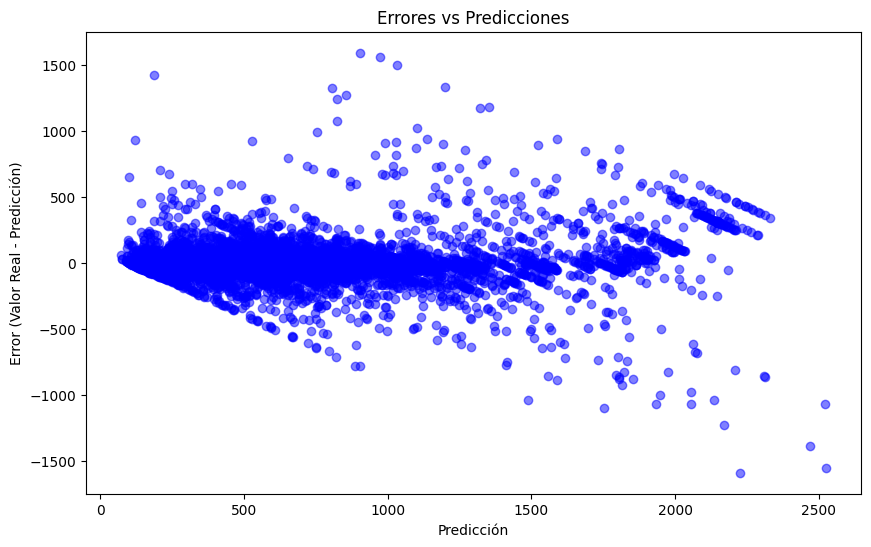

In [ ]:
# Gráfico de dispersión de errores vs predicciones
plt.figure(figsize=(10, 6))
plt.scatter(predicciones_desnormalizadas, errores, color='blue', alpha=0.5)
plt.title('Errores vs Predicciones')
plt.xlabel('Predicción')
plt.ylabel('Error (Valor Real - Predicción)')
plt.show()


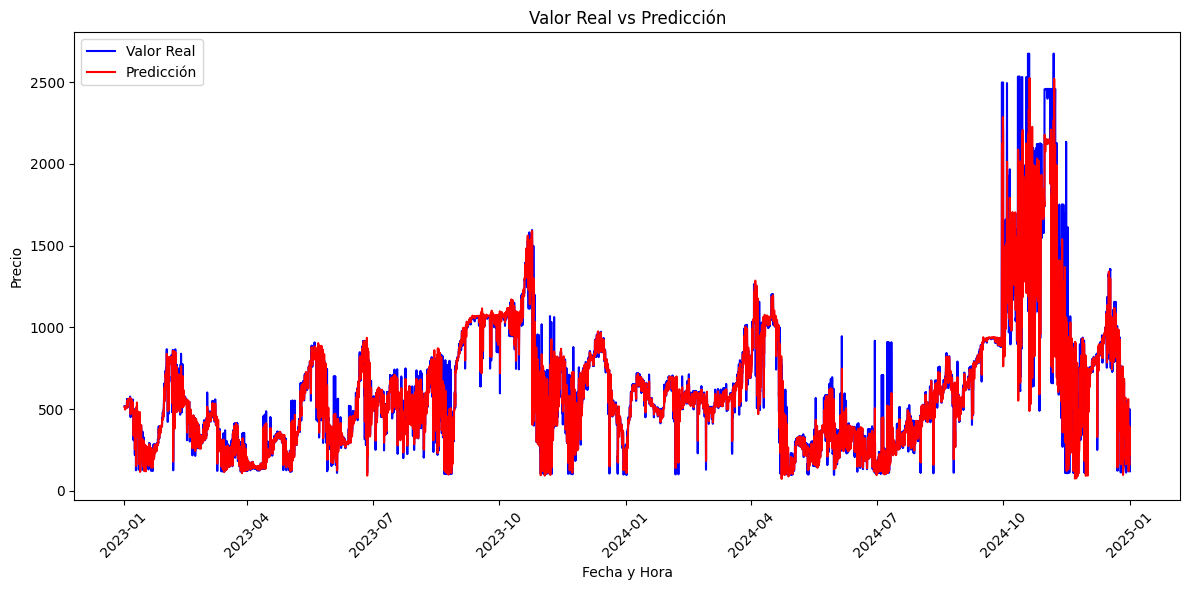

In [ ]:
# Graficar los valores reales y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(resultados['Fecha y Hora'], resultados['Valor Real'], label='Valor Real', color='blue')
plt.plot(resultados['Fecha y Hora'], resultados['Predicción'], label='Predicción', color='red')
plt.title('Valor Real vs Predicción')
plt.xlabel('Fecha y Hora')
plt.ylabel('Precio')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
